Import Libraries

In [31]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import cv2
import tqdm
from torch.utils.data import Dataset
from PIL import Image
import torchvision

In [4]:
mSeed = 99
random.seed(mSeed)
torch.manual_seed(mSeed)
torch.use_deterministic_algorithms(True)


Import Weather Data     

In [5]:
weather_data  = pd.read_csv('../Weather/data/golden_co/weather_data_interpolated.csv')
wColDrop = ['Unnamed: 0.1','Unnamed: 0']
weather_data.drop(columns=wColDrop, inplace=True)
new_column_names = {'{}'.format(col): 'weather_{}'.format(col) for col in weather_data.columns}
weather_data.rename(columns=new_column_names, inplace=True)

type(weather_data['weather_date'][1])
weather_data['weather_date'][1]
weather_data

,weather_date,weather_datetime,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,weather_windspeed,weather_winddir,weather_pressure,weather_visibility,weather_cloudcover,weather_conditions,weather_icon,weather_moonphase
0,2005-01-01,16:00:00,39.8,32.9,48.2,21.8,0.000,0.0,11.3,110.0,1012.9,9.9,50.0,Partially cloudy,partly-cloudy-day,0.71
1,2005-01-02,16:00:00,32.1,32.1,65.5,21.8,0.000,0.0,2.2,280.0,1017.3,9.9,100.0,Overcast,cloudy,0.74
2,2005-01-03,16:00:00,38.9,35.3,57.2,25.1,0.000,0.0,4.9,60.0,1017.6,8.7,50.0,Partially cloudy,partly-cloudy-day,0.75
3,2005-01-04,16:00:00,11.9,3.1,92.3,10.1,0.051,100.0,5.3,50.0,1017.9,1.2,100.0,"Snow, Overcast",snow,0.81
4,2005-01-05,16:00:00,5.1,-7.7,78.5,-0.1,0.000,0.0,7.8,165.0,1014.9,9.9,90.0,Partially cloudy,partly-cloudy-day,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,16:00:00,41.4,35.5,25.5,8.6,0.000,0.0,9.8,322.0,1015.1,9.9,62.6,Partially cloudy,partly-cloudy-day,0.42
5840,2020-12-28,16:00:00,29.2,29.2,87.9,26.1,0.000,0.0,1.3,4.0,1019.0,9.9,100.0,Overcast,cloudy,0.46
5841,2020-12-29,16:00:00,31.8,27.5,67.8,22.4,0.000,0.0,4.3,52.0,1016.0,9.9,19.3,Clear,clear-day,0.50
5842,2020-12-30,16:00:00,39.3,35.9,26.1,7.4,0.000,0.0,4.7,80.0,1017.0,9.9,19.3,Clear,clear-day,0.52


In [6]:
SunsetTimedf =pd.read_csv('../../ImageListwTimeDif.csv')
SunsetTimedf=SunsetTimedf.drop(SunsetTimedf.columns[0],axis=1)
SunsetTimedf['Date'] = SunsetTimedf['ImDate'].str.slice(0,10)
new_column_order = ['imgCode'] + [col for col in SunsetTimedf if col != 'imgCode']
SunsetTimedf = SunsetTimedf[new_column_order]
SunsetTimedf

,imgCode,ImDate,SunTime,TimeDif,Date
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,2005-10-30
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,2005-10-30
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,2005-10-30
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,2005-10-31
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,2005-10-31
...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,2020-02-01
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,2020-02-01
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,2020-02-02
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,2020-02-02


In [7]:
merged_df = pd.merge(SunsetTimedf, weather_data, left_on = "Date", right_on="weather_date", how = "left")
merged_df=merged_df.drop(columns=['Date', 'weather_date', 'weather_datetime','weather_icon'],axis=1)
merged_df = pd.get_dummies(merged_df,columns =['weather_conditions'], dtype = int)
merged_df

,imgCode,ImDate,SunTime,TimeDif,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,...,weather_cloudcover,weather_moonphase,weather_conditions_Clear,weather_conditions_Overcast,weather_conditions_Partially cloudy,"weather_conditions_Rain, Overcast","weather_conditions_Rain, Partially cloudy","weather_conditions_Snow, Fog","weather_conditions_Snow, Overcast","weather_conditions_Snow, Partially cloudy"
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,43.7,39.4,66.5,33.3,0.007,100.0,...,90.0,0.93,0,0,0,0,1,0,0,0
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,50.6,50.6,28.2,18.8,0.000,0.0,...,90.0,0.96,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,57.7,57.7,12.4,6.0,0.000,0.0,...,39.4,0.25,0,0,1,0,0,0,0,0
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,65.5,65.5,8.9,5.0,0.000,0.0,...,15.0,0.29,1,0,0,0,0,0,0,0


In [8]:
SunSetArray  = merged_df.values

In [9]:
SunSetArray

array([['20051030165000.raw.jpg', '2005-10-30 16:50:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['20051030164000.raw.jpg', '2005-10-30 16:40:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['20051030163000.raw.jpg', '2005-10-30 16:30:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ...,
       ['20200202171000.raw.jpg', '2020-02-02 17:10:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['20200202170000.raw.jpg', '2020-02-02 17:00:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['20200202165000.raw.jpg', '2020-02-02 16:50:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0]], dtype=object)

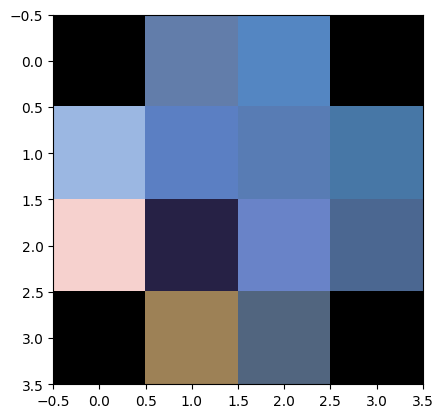

In [10]:
image = cv2.imread("../../Data/SunSetImg/20091204163000.raw.jpg")
image = cv2.resize(image, (4,4),interpolation = cv2.INTER_LINEAR)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [11]:
for row in tqdm.tqdm(SunSetArray):
    image = cv2.imread("../../Data/SunSetImg/" +row[0])
    image_array = np.array(image)
    row[0] = image_array

100%|██████████| 5167/5167 [00:02<00:00, 1778.98it/s]


In [12]:
SunSetArray

array([[array([[[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               ...,

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],


In [13]:
from sklearn.model_selection import train_test_split
im_train, im_test, weather_train, weather_test = train_test_split(SunSetArray[:,0], SunSetArray[:,3:], test_size=0.2, random_state=42)

In [14]:
im_train = im_train/255

In [15]:
np.array(im_train[1]).shape

(288, 288, 3)

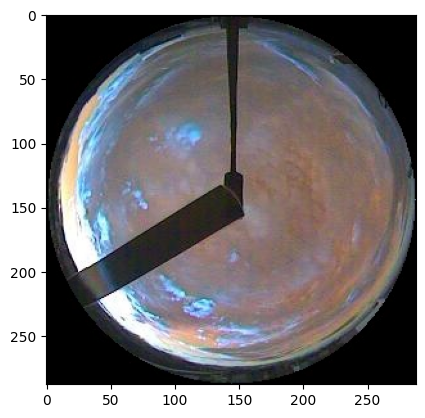

In [16]:
plt.imshow(im_train[1])

Mini Batch

In [17]:
weather_train[0]

array([-25.783333333333303, 40.2, 32.8, 23.7, 5.9, 0.0, 0.0, 12.8, 12.0,
       1018.9, 14.8, 35.2, 0.08, 0, 0, 1, 0, 0, 0, 0, 0], dtype=object)

In [18]:
weather_train[0].shape

(21,)

In [19]:
np.sqrt(12288/3)

64.0

In [20]:
def sample_noise(size, device, dim=100):
    return torch.rand((size, dim), device=device)

Generator

In [21]:
class Generator(nn.Module):
    def __init__(self,latent_dim = 30, context_dim = 21):
        print("latent", latent_dim)
        print("context", context_dim)
        super(Generator,self).__init__()
        self.hidden1_latent = nn.Sequential(nn.Linear(latent_dim,30), nn.Dropout(p=.5), nn.ReLU(),)
        self.hidden1_context = nn.Sequential(nn.Linear(context_dim,30))
        self.hidden2 = nn.Sequential(nn.Linear(60,48),nn.Dropout(p=.5), nn.ReLU(), )

        self.hidden3 = nn.Sequential(nn.ConvTranspose2d(3,256,1,1,0), nn.Dropout(p=.5),nn.ReLU())
        self.out_layer0 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Tanh(),)

        self.hidden4 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden5 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # First Progression output
        self.out_layer1 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden6 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden7 = nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Second Progression output
        self.out_layer2 = nn.Sequential(nn.Conv2d(256,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden8 = nn.Sequential(nn.ConvTranspose2d(256,256,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden9 = nn.Sequential(nn.Conv2d(256,128,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # FirsThirdt Progression output
        self.out_layer3 = nn.Sequential(nn.Conv2d(128,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------

        self.hidden10 = nn.Sequential(nn.ConvTranspose2d(128,128,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden11 = nn.Sequential(nn.Conv2d(128,64,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Fourth Progression output
        self.out_layer4 = nn.Sequential(nn.Conv2d(64,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------
        self.hidden12 = nn.Sequential(nn.ConvTranspose2d(64,64,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden13 = nn.Sequential(nn.Conv2d(64,32,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)
        # Fithf Progression output
        self.out_layer5 = nn.Sequential(nn.Conv2d(32,3, 1, 1, 0, bias=False),nn.Tanh(),)
        #------------------------------------------------------------------------------------------
        self.hidden14 = nn.Sequential(nn.ConvTranspose2d(32,32,4,2,1), nn.Dropout(p=.5),nn.ReLU(),)
        self.hidden15 = nn.Sequential(nn.Conv2d(32,32,3,1,1), nn.Dropout(p=.5),nn.ReLU(),)


        # self.hidden2 = nn.Sequential(nn.Linear(1200, 1200), nn.Dropout(p=0.5), nn.ReLU(),)
        self.out_layerFinal = nn.Sequential(nn.ConvTranspose2d(32, 3, 1, 1, 0, bias=False),nn.Tanh(),)

    def forward(self, noise, context, passthrough = 6):
        noise = noise.view(noise.size(0), -1)
        context = context.view(context.size(0), -1)

        print("noise", noise.shape)
        print("context", context.shape)
        
        h = torch.cat((self.hidden1_latent(noise), self.hidden1_context(context)), dim=1)
        h = self.hidden2(h)
        h = h.view(-1, 3, 16, 1)
        h = self.hidden3(h)
        print('h', h.shape)
        if passthrough == 0:
            h = self.out_layer0(h)
            return h
        h = self.hidden4(h)
        h = self.hidden5(h)
        if passthrough == 1:
            h = self.out_layer1(h)
            return h
        h = self.hidden6(h)
        h = self.hidden7(h)
        if passthrough == 2:
            h = self.out_layer2(h)
            return h
        h = self.hidden8(h)
        h = self.hidden9(h)
        if passthrough == 3:
            h = self.out_layer3(h)
            return h
        h = self.hidden10(h)
        h = self.hidden11(h)
        if passthrough == 4:
            h = self.out_layer4(h)
            return h
        h = self.hidden12(h)
        h = self.hidden13(h)
        if passthrough == 5:
            h = self.out_layer5(h)
            return h
        h = self.hidden14(h)
        h = self.hidden15(h)

        h = self.out_layerFinal(h)
        return h

In [22]:
device = torch.device('cpu')

noise = sample_noise(1, device=device, dim=30)
fake_weather = sample_noise(1, device=device, dim=21)

Gen = Generator().to(device)
x = Gen(noise, fake_weather, 3) 

print(x.shape) 

latent 30
context 21
noise torch.Size([1, 30])
context torch.Size([1, 21])
h torch.Size([1, 256, 16, 1])
torch.Size([1, 3, 128, 8])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [23]:
z = x.cpu().detach().numpy()

In [24]:
z.shape

(1, 3, 128, 8)

In [25]:
np.transpose(z, (1, 2, 0)).shape

ValueError: axes don't match array

In [36]:
class Discriminator(nn.Module):

    def __init__(self, input_dim=256*256*3, context_dim=21):
        super(Discriminator, self).__init__()
        #Image Processing

        # 256*256
        self.hidden1 = nn.Sequential(nn.Conv2d(3,32,5,1,2), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden2 = nn.Sequential(nn.Conv2d(32,32,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #128*128
        self.h128x128 = nn.Sequential(nn.Conv2d(3,64,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden3 =  nn.Sequential(nn.Conv2d(32,64,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden4 =  nn.Sequential(nn.Conv2d(64,64,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #64*64
        self.h64x64 = nn.Sequential(nn.Conv2d(3,128,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden5 =  nn.Sequential(nn.Conv2d(64,128,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden6 =  nn.Sequential(nn.Conv2d(128,128,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #32*32
        self.h32x32 = nn.Sequential(nn.Conv2d(3,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden7 =  nn.Sequential(nn.Conv2d(128,256,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden8 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #16*16
        self.h16x16 = nn.Sequential(nn.Conv2d(3,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden9 =  nn.Sequential(nn.Conv2d(256,256,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden10 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #8*8
        self.h8x8 = nn.Sequential(nn.Conv2d(3,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden11 =  nn.Sequential(nn.Conv2d(256,256,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden12 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)

        #4*4
        self.h4x4 = nn.Sequential(nn.Conv2d(3,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU())
        self.hidden13 =  nn.Sequential(nn.Conv2d(256,256,3,2,1), nn.Dropout(.2), nn.LeakyReLU(),)
        self.hidden14 =  nn.Sequential(nn.Conv2d(256,256,3,1,1), nn.Dropout(.2), nn.LeakyReLU(),)


        #Weather Processing

        self.weather1 = nn.Sequential(nn.Linear(21, 30), nn.Dropout(.2), nn.LeakyReLU())
        # Adjusted Linear Layers
        self.m1 = nn.Sequential(nn.Linear(286, 30), nn.Dropout(.2), nn.LeakyReLU())
        self.m2 = nn.Sequential(nn.Linear(30, 1), nn.Dropout(.2), nn.Sigmoid())

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, image, weather, passthru = 6):
        print("Initial Image Shape:", image.shape)
        print("Weather Shape:", weather.shape)
        #256x256
        if passthru >5 :
            h = self.hidden1(image)
            print(h.shape)
            h= self.hidden2(h)
            print(h.shape)

            h = self.hidden3(h)
            print(h.shape)
            h = self.hidden4(h)
            print(h.shape)

            h = self.hidden5(h)
            print(h.shape)
            h = self.hidden6(h)
            print(h.shape)

            h = self.hidden7(h)
            print(h.shape)
            h = self.hidden8(h)
            print(h.shape)

            h = self.hidden9(h)
            print(h.shape)
            h = self.hidden10(h)
            print(h.shape)

            h = self.hidden11(h)
            print(h.shape)

            h = self.hidden12(h)
            print(h.shape)

            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)


        #128x128
        if passthru == 5:
            h = self.h128x128(image)
            h = self.hidden4(h)
            print(h.shape)

            h = self.hidden5(h)
            print(h.shape)
            h = self.hidden6(h)
            print(h.shape)

            h = self.hidden7(h)
            print(h.shape)
            h = self.hidden8(h)
            print(h.shape)

            h = self.hidden9(h)
            print(h.shape)
            h = self.hidden10(h)
            print(h.shape)

            h = self.hidden11(h)
            print(h.shape)

            h = self.hidden12(h)
            print(h.shape)

            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)

        #64x64
        if passthru == 4:
            h = self.h64x64(image)
            h = self.hidden6(h)
            print(h.shape)

            h = self.hidden7(h)
            print(h.shape)
            h = self.hidden8(h)
            print(h.shape)

            h = self.hidden9(h)
            print(h.shape)
            h = self.hidden10(h)
            print(h.shape)

            h = self.hidden11(h)
            print(h.shape)

            h = self.hidden12(h)
            print(h.shape)

            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)

        #32x32
        if passthru == 3:
            h = self.h32x32(image)
            h = self.hidden8(h)
            print(h.shape)

            h = self.hidden9(h)
            print(h.shape)
            h = self.hidden10(h)
            print(h.shape)

            h = self.hidden11(h)
            print(h.shape)

            h = self.hidden12(h)
            print(h.shape)

            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)


        #16x16
        if passthru == 2:
            h = self.h16x16(image)
            h = self.hidden10(h)
            print(h.shape)

            h = self.hidden11(h)
            print(h.shape)

            h = self.hidden12(h)
            print(h.shape)

            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)

        #8x8
        if passthru == 1:
            h = self.h8x8(image)
            print(h.shape)
            h = self.hidden12(h)
            print(h.shape)
            h = self.hidden13(h)
            print(h.shape)
            h = self.hidden14(h)
            print(h.shape)


        #4x4
        if passthru == 0:
            h =self.h4x4(image)
            h = self.hidden14(h)
            print(h.shape)

        # Assume 'h' is the final output from the convolutional blocks
        print("Output from last conv layer:", h.shape)
        h = self.adaptive_pool(h)
        h = h.view(h.size(0), -1)  # Flatten
        print("Flattened output:", h.shape)

        # Process weather conditions
        w = self.weather1(weather)
        print("Processed weather:", w.shape)
        w = w.view(w.size(0), -1)
        print("Flattened weather:", w.shape)

        # Concatenate image and weather outputs
        combined_input = torch.cat((h, w), dim=1)
        print("Combined input size:", combined_input.shape)

        # Pass combined input through linear layers
        m = self.m1(combined_input)
        print("After first linear layer:", m.shape)
        m = self.m2(m)
        print("Final output size:", m.shape)
        return m

In [ ]:
noise = sample_noise(1,device = device, dim = 30)
fake_weather = sample_noise(1, device = device, dim = 21)

Gen = Generator().to(device)
x = Gen(noise,fake_weather,5)
print("--------")
print(x.shape)

--------
torch.Size([3, 128, 128])


In [ ]:
x.shape

torch.Size([3, 128, 128])

In [ ]:
noise = sample_noise(1,device = device, dim = 30)
fake_weather = sample_noise(1, device = device, dim = 21)
disc = Discriminator().to(device)
y = disc(x, fake_weather,5)
y

Initial Image Shape: torch.Size([3, 128, 128])
Weather Shape: torch.Size([1, 21])
torch.Size([64, 128, 128])
torch.Size([128, 64, 64])
torch.Size([128, 64, 64])
torch.Size([256, 32, 32])
torch.Size([256, 32, 32])
torch.Size([256, 16, 16])
torch.Size([256, 16, 16])
torch.Size([256, 8, 8])
torch.Size([256, 8, 8])
torch.Size([256, 8, 8])
torch.Size([256, 4, 4])
torch.Size([256, 4, 4])
Output from last conv layer: torch.Size([256, 4, 4])
Flattened output: torch.Size([1, 4096])
torch.Size([1, 21])
Processed weather: torch.Size([1, 30])
Flattened weather: torch.Size([1, 30])
Combined input size: torch.Size([1, 4126])
After first linear layer: torch.Size([1, 30])
Final output size: torch.Size([1, 1])


tensor([[0.5000]], grad_fn=<SigmoidBackward0>)

# TRAINING


In [27]:
# Number of channels in the training images
nc = 3

# Size of z latent vector
latent_dim = 30

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed noise & context for checking the generator's progress
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
fixed_context = torch.randn(64, 21, device=device)


In [28]:
im_train_uint8 = np.array([[np.array(image) * 255 for image in row] for row in im_train], dtype=np.uint8)

In [29]:
class ImageWeatherDataset(Dataset):
    def __init__(self, images, weather_data, transform=None):
        self.weather_data = weather_data
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert image array to PIL Image
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        
        # Extract weather data for the current index
        weather = self.weather_data[idx].astype('float32')
        
        return image, weather


image_size = 64
batch_size = 64
workers = 0

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageWeatherDataset(images=im_train_uint8, weather_data=weather_train, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

real_batch = next(iter(dataloader))
images, weathers = real_batch[0].to(device), real_batch[1].to(device)

In [ ]:
weathers.shape

torch.Size([64, 21])

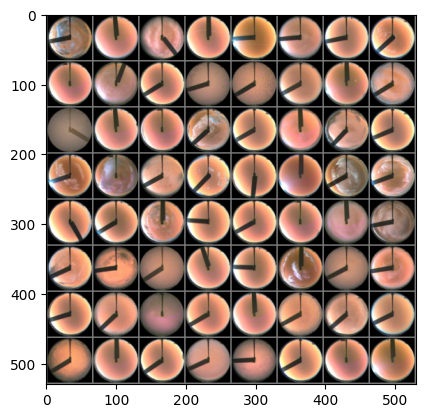

In [33]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [37]:
criterion = nn.BCELoss()

netG = Generator(latent_dim=30, context_dim=21).to(device)
netD = Discriminator(input_dim=256*256*3, context_dim=21).to(device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

latent 30
context 21


In [42]:
from tqdm import tqdm

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in tqdm(range(num_epochs)):

    for i, data in enumerate(dataloader, 0):
        print(i)
        real_images, weather_conditions = data

        real_images = real_images.to(device).float() 
        weather_conditions = weather_conditions.to(device).float() 

        b_size = real_images.size(0)

        # Update D network: maximize log(D(x|c)) + log(1 - D(G(z|c)))
        netD.zero_grad()

        real_label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0, dtype=torch.float, device=device)

        output_real = netD(real_images, weather_conditions).view(-1)

        errD_real = criterion(output_real, real_label)
        errD_real.backward()
        D_x = output_real.mean().item()

        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)

        print("noise", noise.shape)
        print("weather", weather_conditions.shape)
        fake_images = netG(noise, weather_conditions)

        output_fake = netD(fake_images.detach(), weather_conditions).view(-1)
        
        errD_fake = criterion(output_fake, fake_label)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network: maximize log(D(G(z|c)))
        netG.zero_grad()
        output_fake = netD(fake_images, weather_conditions).view(-1)
        errG = criterion(output_fake, real_label)
        errG.backward()
        D_G_z2 = output_fake.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z1)): %.4f / D(G(z2)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_context).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/5 [00:00<?, ?it/s]

0
Initial Image Shape: torch.Size([64, 3, 64, 64])
Weather Shape: torch.Size([64, 21])
torch.Size([64, 32, 64, 64])
torch.Size([64, 32, 64, 64])
torch.Size([64, 64, 32, 32])
torch.Size([64, 64, 32, 32])
torch.Size([64, 128, 16, 16])
torch.Size([64, 128, 16, 16])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 1, 1])
torch.Size([64, 256, 1, 1])
Output from last conv layer: torch.Size([64, 256, 1, 1])
Flattened output: torch.Size([64, 256])
Processed weather: torch.Size([64, 30])
Flattened weather: torch.Size([64, 30])
Combined input size: torch.Size([64, 286])
After first linear layer: torch.Size([64, 30])
Final output size: torch.Size([64, 1])
noise torch.Size([64, 30, 1, 1])
weather torch.Size([64, 21])
noise torch.Size([64, 30])
context torch.Size([64, 21])
h torch.Size([64, 256, 16, 1])
Initial Image Shape: torch.Siz

 20%|██        | 1/5 [40:47<2:43:09, 2447.30s/it]

0
Initial Image Shape: torch.Size([64, 3, 64, 64])
Weather Shape: torch.Size([64, 21])
torch.Size([64, 32, 64, 64])
torch.Size([64, 32, 64, 64])
torch.Size([64, 64, 32, 32])
torch.Size([64, 64, 32, 32])
torch.Size([64, 128, 16, 16])
torch.Size([64, 128, 16, 16])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 1, 1])
torch.Size([64, 256, 1, 1])
Output from last conv layer: torch.Size([64, 256, 1, 1])
Flattened output: torch.Size([64, 256])
Processed weather: torch.Size([64, 30])
Flattened weather: torch.Size([64, 30])
Combined input size: torch.Size([64, 286])
After first linear layer: torch.Size([64, 30])
Final output size: torch.Size([64, 1])
noise torch.Size([64, 30, 1, 1])
weather torch.Size([64, 21])
noise torch.Size([64, 30])
context torch.Size([64, 21])
h torch.Size([64, 256, 16, 1])
Initial Image Shape: torch.Siz

 40%|████      | 2/5 [1:21:50<2:02:49, 2456.57s/it]

0
Initial Image Shape: torch.Size([64, 3, 64, 64])
Weather Shape: torch.Size([64, 21])
torch.Size([64, 32, 64, 64])
torch.Size([64, 32, 64, 64])
torch.Size([64, 64, 32, 32])
torch.Size([64, 64, 32, 32])
torch.Size([64, 128, 16, 16])
torch.Size([64, 128, 16, 16])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 8, 8])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 4, 4])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 2, 2])
torch.Size([64, 256, 1, 1])
torch.Size([64, 256, 1, 1])
Output from last conv layer: torch.Size([64, 256, 1, 1])
Flattened output: torch.Size([64, 256])
Processed weather: torch.Size([64, 30])
Flattened weather: torch.Size([64, 30])
Combined input size: torch.Size([64, 286])
After first linear layer: torch.Size([64, 30])
Final output size: torch.Size([64, 1])
noise torch.Size([64, 30, 1, 1])
weather torch.Size([64, 21])
noise torch.Size([64, 30])
context torch.Size([64, 21])
h torch.Size([64, 256, 16, 1])
Initial Image Shape: torch.Siz